## Introductory Information

### Project Goal - **Segmentation as Clusterization**

**Goal**: Unsupervised segmentation of simple images

1. Train a simple **U-Net** model for supervised segmentation.
2. To extract useful features train an autoencoder U-net model that reconstructs an image.
3. Cluster the intermediate features of the model.
4. Use cluster assignments as weak segments
5. Compare performance at different depths in the model

**Bonus**: Learn weak clusterization (Slot attention)

### Dataset Used

The **CLEVR (with masks)** Dataset

The title of the dataset is **Multi-Object Datasets**, it was published in the year 2019. In this project we use only the **CLEVR (with masks)** subset of data, stored initially in TFRecords format and transformed after into pickle data.

The dataset used can be found at the following <a href="https://github.com/deepmind/multi_object_datasets" target="_blank">GitHub Repository</a>.

The authors consist of the following people:
 * Kabra
 * Rishabh and Burgess
 * Chris and Matthey
 * Loic and Kaufman
 * Raphael Lopez and Greff
 * Klaus and Reynolds
 * Malcolm and Lerchner
 * Alexander

### Dataset Insights

#### Preview Dataset Images

By using only a subpart of the dataset and analysing it we can observe some characteristics such as:

1. The format of the dataset that we used is: **Pickle** because it is easier to work with in the Pytorch environment.
2. The subset contains 7000 images for the training phase and 1000 for testing purposes.
3. There are 3 types of shapes: spheres, cubes and cylinders. They are available in different colors and materials.
4. The number of objects present in an images varies between 1 and 11 (including the background).

In [2]:
from src.SegmentationDataset import SegmentationDataset
import matplotlib.pyplot as plt
import random

# Define the training dataset
train_dataset = SegmentationDataset(mode='train')

# Create a figure to draw upon
fig = plt.figure()

# Adjust figure properties
fig.set_figwidth(30)
fig.set_figheight(15)

# Preview five random images from the dataset
for idx in range(5):
    # Fetch a random image from the training dataset
    random_image_index = random.randrange(0, len(train_dataset))

    # Extract the entry at the random index
    entry = train_dataset[random_image_index]

    # Extract an image from the dataset
    image, masks, count = entry['image'], entry['mask'], entry['count']

    # Specify a subplot
    plt.subplot(1, 5, idx + 1)

    # Specify the title of the image
    plt.title(f'Training Image {random_image_index}')
    
    # Add additional information in the subplots
    plt.ylabel('Pixel Height')
    plt.xlabel(f'Pixel Width\n\nNumber of objects: {count}')

    # Draw the image on screen
    plt.imshow(image.permute(1, 2, 0))

Loaded ./data/input/train_test_clevr_pkls/train_clevr_3000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_5000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_6000.pkl in memory.


#### Preview Dataset Masks

Each image in the dataset has an array of **masks** associated with it, which specifies the perfect segmentation of the objects. Take as an example the following image:

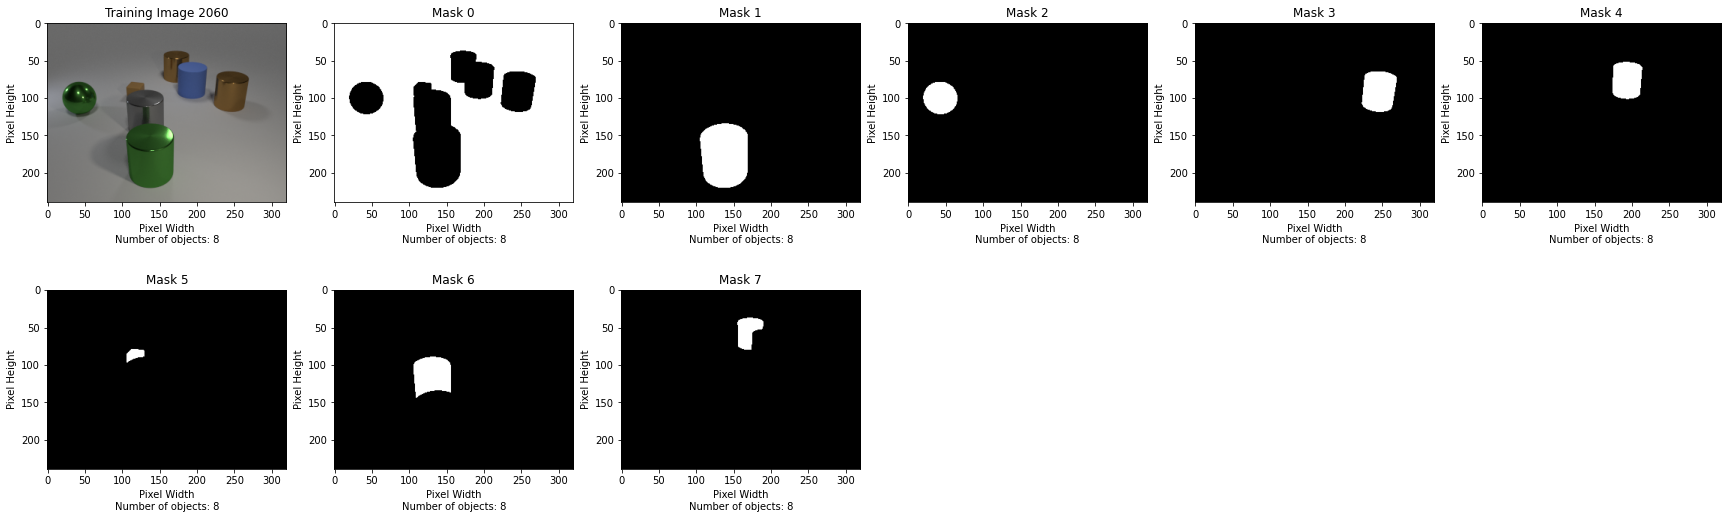

In [ ]:
import matplotlib.pyplot as plt
import random

# Fetch a random image from the training dataset
random_image_index = random.randrange(0, len(train_dataset))

# Extract a random entry
entry = train_dataset[random_image_index]

# Extract an image from the dataset
image, masks, count = entry['image'], entry['mask'], entry['count']

# Create a figure to draw upon
fig = plt.figure()

# Adjust figure properties
fig.set_figwidth(30)
fig.set_figheight(9)

# Show original image
plt.subplot(2, 6, 1)

# Specify the title of the image
plt.title(f'Training Image {random_image_index}')

# Add additional information in the subplot
plt.ylabel('Pixel Height')
plt.xlabel(f'Pixel Width\nNumber of objects: {count}')

# Draw the orignal image on screen
plt.imshow(image.permute(1, 2, 0))

# Show all masks
for idx, mask in enumerate(masks[:int(count)]):
    # Specify a subplot
    plt.subplot(2, 6, idx + 2)

    # Specify the title of the image
    plt.title(f'Mask {idx}')

    # Add additional information in the subplot
    plt.ylabel('Pixel Height')
    plt.xlabel(f'Pixel Width\nNumber of objects: {count}')
    
    # Draw the image on screen
    plt.imshow(mask.repeat(3, 1, 1).permute(1, 2, 0))

#### Calculate the Percentages of Gray and Non-Gray Pixels in Images

In [ ]:
from src.SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from src.Config.Args import args
from src.Process import gray_map

# Define the training dataset and loader
train_dataset = SegmentationDataset(mode='train')
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

# Count the total amount of gray pixels and non-gray pixels
total_non_gray_samples = 0
total_gray_samples = 0

for entry in train_loader:
    # Extract individual keys from the entry
    images, masks, clusters = entry['image'], entry['mask'], entry['count']

    # Calculate the number of gray samples
    gray_samples = gray_map(images).sum()

    # Add the gray samples to the total count
    total_gray_samples += gray_samples

    # Calculate the number of non-gray samples
    non_gray_samples = images.numel() // 3 - gray_samples

    # Add the non-gray samples to the total count
    total_non_gray_samples += non_gray_samples

# Calculate gray and non-gray weights
old_non_gray_weight = 1. / total_non_gray_samples
old_gray_weight = 1. / total_gray_samples

# Normalize the values
non_gray_weight = old_non_gray_weight / (old_non_gray_weight + old_gray_weight)
gray_weight = old_gray_weight / (old_non_gray_weight + old_gray_weight)

# Print the percentages for gray and non-gray pixels
print(f'Non-Gray Pixels: {100. * non_gray_weight:.02f}%')
print(f'Gray Pixels: {100. * gray_weight:.02f}%')

Non-Gray Pixels: 72.76%
Gray Pixels: 27.24%


## Create **Dataset** and **DataLoaders** to facilitate the training process

In [1]:
from src.SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from src.Config.Args import args

# Define the datasets for both training and testing
test_dataset = SegmentationDataset(mode='test')
train_dataset = SegmentationDataset(mode='train')

# Define the dataloaders for both training and testing
test_loader = DataLoader(test_dataset, args.test_batch_size, args.shuffle)
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

## Using Unsupervised Models on the **CLEVR (with masks)** Dataset

### Specify the Model Type

In [3]:
from src.Utils import make_model

# The name of the model that is to be used
model_name = 'UNet'

# The color scheme of the image
image_type = 'rgb'

# Load the custom 'UNet' or 'AutoEncoder' model for 'rgb' or 'grayscale' images
model_type, model_weights_path, transform = make_model(name=model_name, image_type=image_type)

### Instantiate the Model

In [ ]:
import torch

# Instantiate the model and send it to the GPU
model = model_type(n_filters=args.n_filters).to(args.device)

# Define a custom optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learn_rate, weight_decay=args.weight_decay)

# Specify a custom loss function
criterion = torch.nn.MSELoss()

### Train the Model

In [ ]:
from src.Plotter import plot_loss
from src.Train import train
import torch

# Retain the loss evolution
losses_train = []

# Train the model for a number of epochs
for epoch in range(args.epochs):
    # Train the model for one epoch
    train_loss = train(model, train_loader, optimizer, criterion, epoch, transform)

    # Retain the current loss
    losses_train.append(train_loss)

    # Separate the outputs
    print()

# Plot the loss evolution
plot_loss(losses_train, 'train_loss', 'Train Loss', 'Epoch', 'Loss')

Loaded ./data/input/train_test_clevr_pkls/train_clevr_6000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_7000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_5000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_4000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_2000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_1000.pkl in memory.
Train Epoch: 0 [0/7000 (0%)]	Loss: 0.18357601761817932
Loaded ./data/input/train_test_clevr_pkls/train_clevr_3000.pkl in memory.
Train Epoch: 0 [1000/7000 (14%)]	Loss: 0.001626478275284171
Train Epoch: 0 [2000/7000 (29%)]	Loss: 0.001157713239081204


KeyboardInterrupt: 

The model should also be saved on disk to avoid future reprocessing.

In [ ]:
# Save the weights on disk
torch.save(model.state_dict(), model_weights_path)

### Load the Model

In [4]:
import torch

# Instantiate the model and send it to the GPU
model = model_type(n_filters=args.n_filters).to(args.device)

# Load the model trained parameters in memory
model.load_state_dict(torch.load(model_weights_path))

<All keys matched successfully>

### Preview Some Outputs on the Test Dataset

#### Preview Output For Image Reconstruction Task

Loaded ./data/input/train_test_clevr_pkls/test_clevr_8000.pkl in memory.


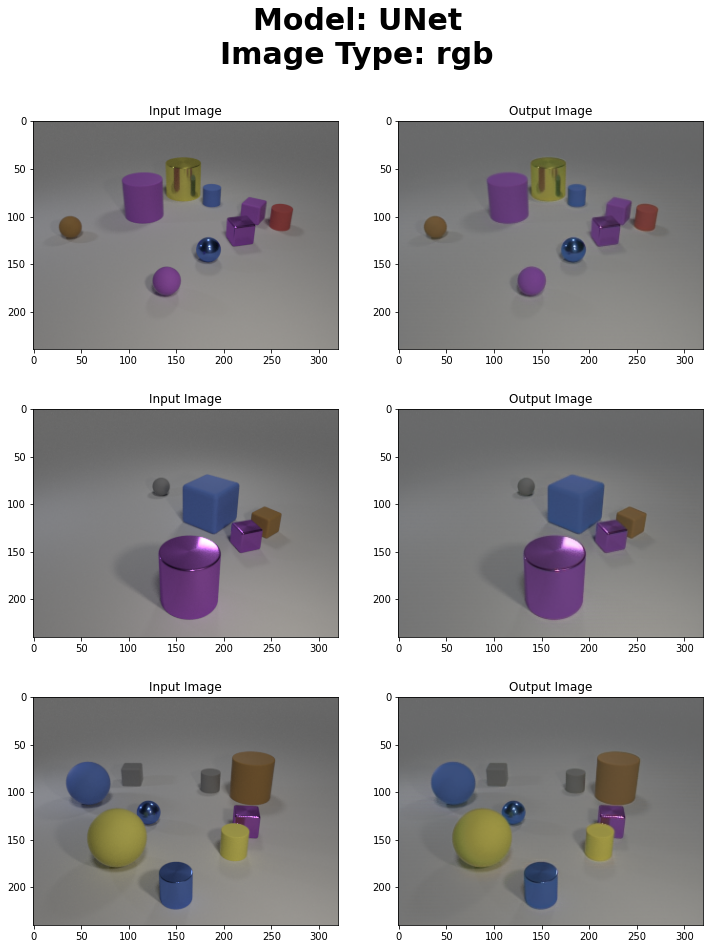

In [ ]:
from src.Process import unprocess
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a new figure
f = plt.figure()

# Set figure properties
f.suptitle(f'Model: {model_name}\nImage Type: {image_type}', fontsize=30, fontweight='bold')
f.set_figheight(15)
f.set_figwidth(12)

# Set the number of samples
current_subplot = 1
total_subplots = 3

for batch_idx, entry in enumerate(test_loader):
    # Extract columns from the entry
    images, masks, counts = entry['image'], entry['mask'], entry['count']
    
    # Print only a number of outputs
    if batch_idx == total_subplots:
        break

    # Specify the input image
    img_true = images[0]

    # Calculate the predicted image and transform it from [0, 1] -> [0, 255]
    img_pred = unprocess(model(transform(img_true.unsqueeze(0).to(args.device)))).cpu()
    
    # Plot input image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_true.permute(1, 2, 0))
    plt.title('Input Image')
    current_subplot += 1

    # Plot output image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_pred.squeeze(0).permute(1, 2, 0))
    plt.title('Output Image')
    current_subplot += 1

# Save the plot
plt.savefig(f'{args.output_dir}/reconstruction/{model_name}_{image_type}.jpg')

# Plot the images
plt.show()

#### Preview Output For K-Means Clustering Using Cosine Similarity

Send an image through the model and show the reconstruction output.

Size of image: torch.Size([76800, 3])
Object count: 11


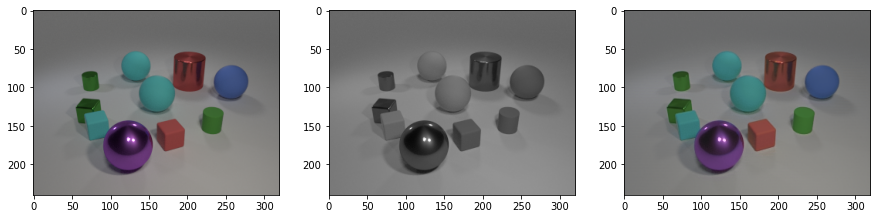

In [ ]:
from src.Process import make_grayscale, unprocess
import random

# Fetch entry
index = int(random.uniform(0, 1000))
entry = test_dataset[index]
image, masks, count = entry['image'], entry['mask'], entry['count']

# Send masks to device
masks = masks.to(args.device)

# Store original image
original = image.clone()

# Store the processed image
proc_img = make_grayscale(image.unsqueeze(0)).squeeze(0)

# Pass through model
out_img = unprocess(model(transform(image.unsqueeze(0)).to(args.device))).squeeze(0)

# Reshape image
image = out_img.permute(1, 2, 0).to(torch.float)
image = image.reshape(-1, image.shape[2])

# Set figure properties
f = plt.figure()
f.set_figheight(20)
f.set_figwidth(15)

# Show original image
plt.subplot(1, 3, 1)
plt.imshow(original.permute(1, 2, 0))
print(f'Size of image: {image.shape}')
print(f'Object count: {count}')

# Show grayscale image
plt.subplot(1, 3, 2)
plt.imshow(proc_img.permute(1, 2, 0))

# Show grayscale image
plt.subplot(1, 3, 3)
plt.imshow(out_img.cpu().permute(1, 2, 0))

Use K-Means Clustering on the resulting feature maps from the model.

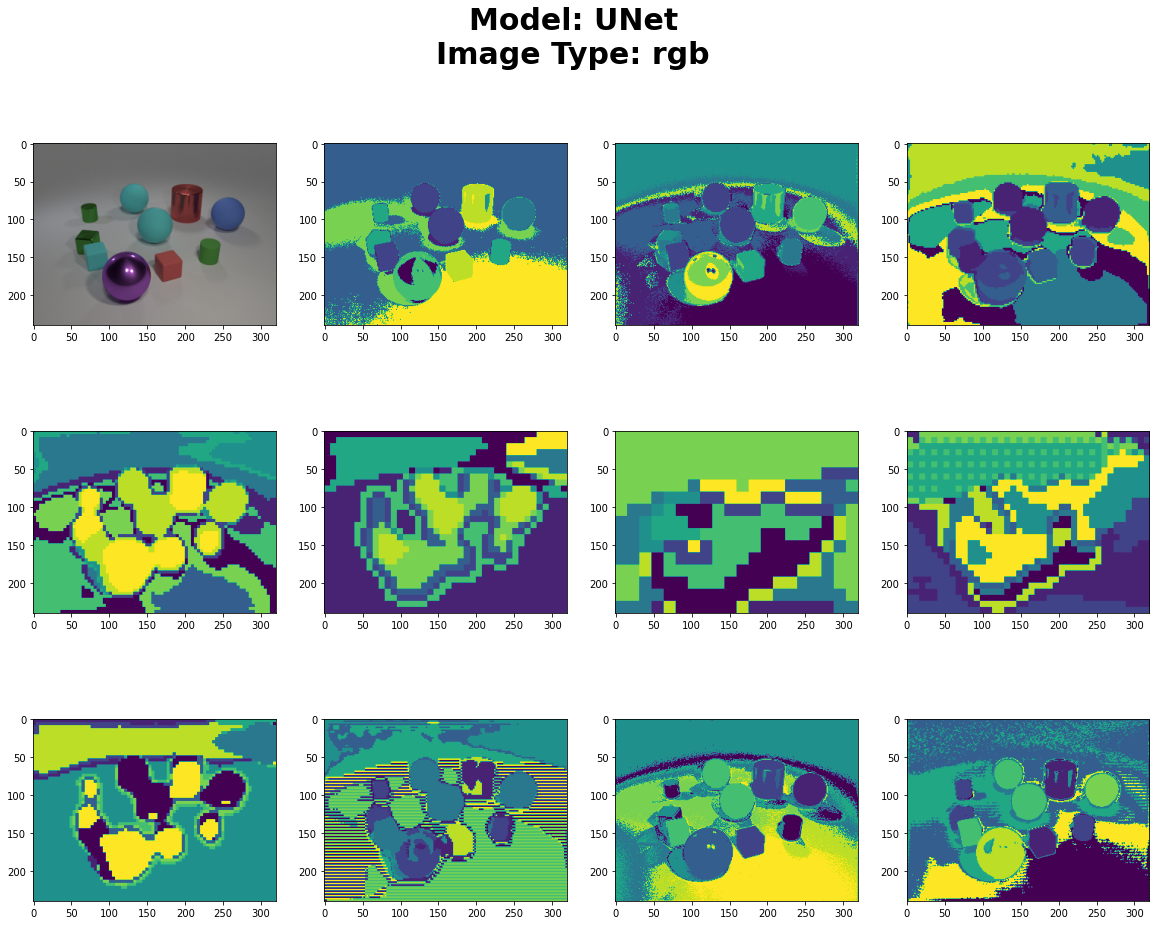

In [ ]:
from src.KMeans import KMeans_cosine

# Create a new figure
fig = plt.figure()

# Set the properties of the figure
fig.suptitle(f'Model: {model_name}\nImage Type: {image_type}', fontsize=30, fontweight='bold')
fig.set_figwidth(20)
fig.set_figheight(15)

# Plot initial image
plt.subplot(3, 4, 1)
plt.imshow(model.feature_maps[0].squeeze(0).permute(1, 2, 0).cpu())
mask_labels = list(range(len(model.feature_maps)))

for idx, hmap in enumerate(model.feature_maps):
    # Check if image_type is grayscale or rgb
    if image_type == 'grayscale' and idx == 0:
        continue

    # Define the custom upsampler
    up = torch.nn.Upsample(scale_factor=240 / hmap.shape[2], mode='nearest')

    # Get the initial sizes
    N, C, H, W = hmap.shape

    # Send the data to the device
    hmap = hmap.to(args.device)

    # Permute the dimensions
    hmap = hmap.squeeze(0).permute(1, 2, 0)
    
    # Concat pixels
    hmap = hmap.reshape((-1, hmap.shape[2]))

    # Make the memory contiguous
    hmap = hmap.contiguous()

    # Run the K-Means algorithm
    labels = KMeans_cosine(hmap, K=count, n_init=10, max_iter=300, tol=1e-5)

    # Select current subplot
    plt.subplot(3, 4, idx + 2)

    # Reshape the labels to the initial size: (H, W)
    labels = labels.reshape((H, W))

    # Add additional dimensions for upsampling
    labels = labels.unsqueeze(0).unsqueeze(0)

    # Upsample the labels
    labels = up(labels.float()).squeeze(0)
    
    # Plot the resulting image
    plt.imshow(labels.cpu().squeeze(0))

    mask_labels[idx] = labels

# Plot the images
plt.show()

Plot the separate masks obtained from the K-Means Clustering algorithm.

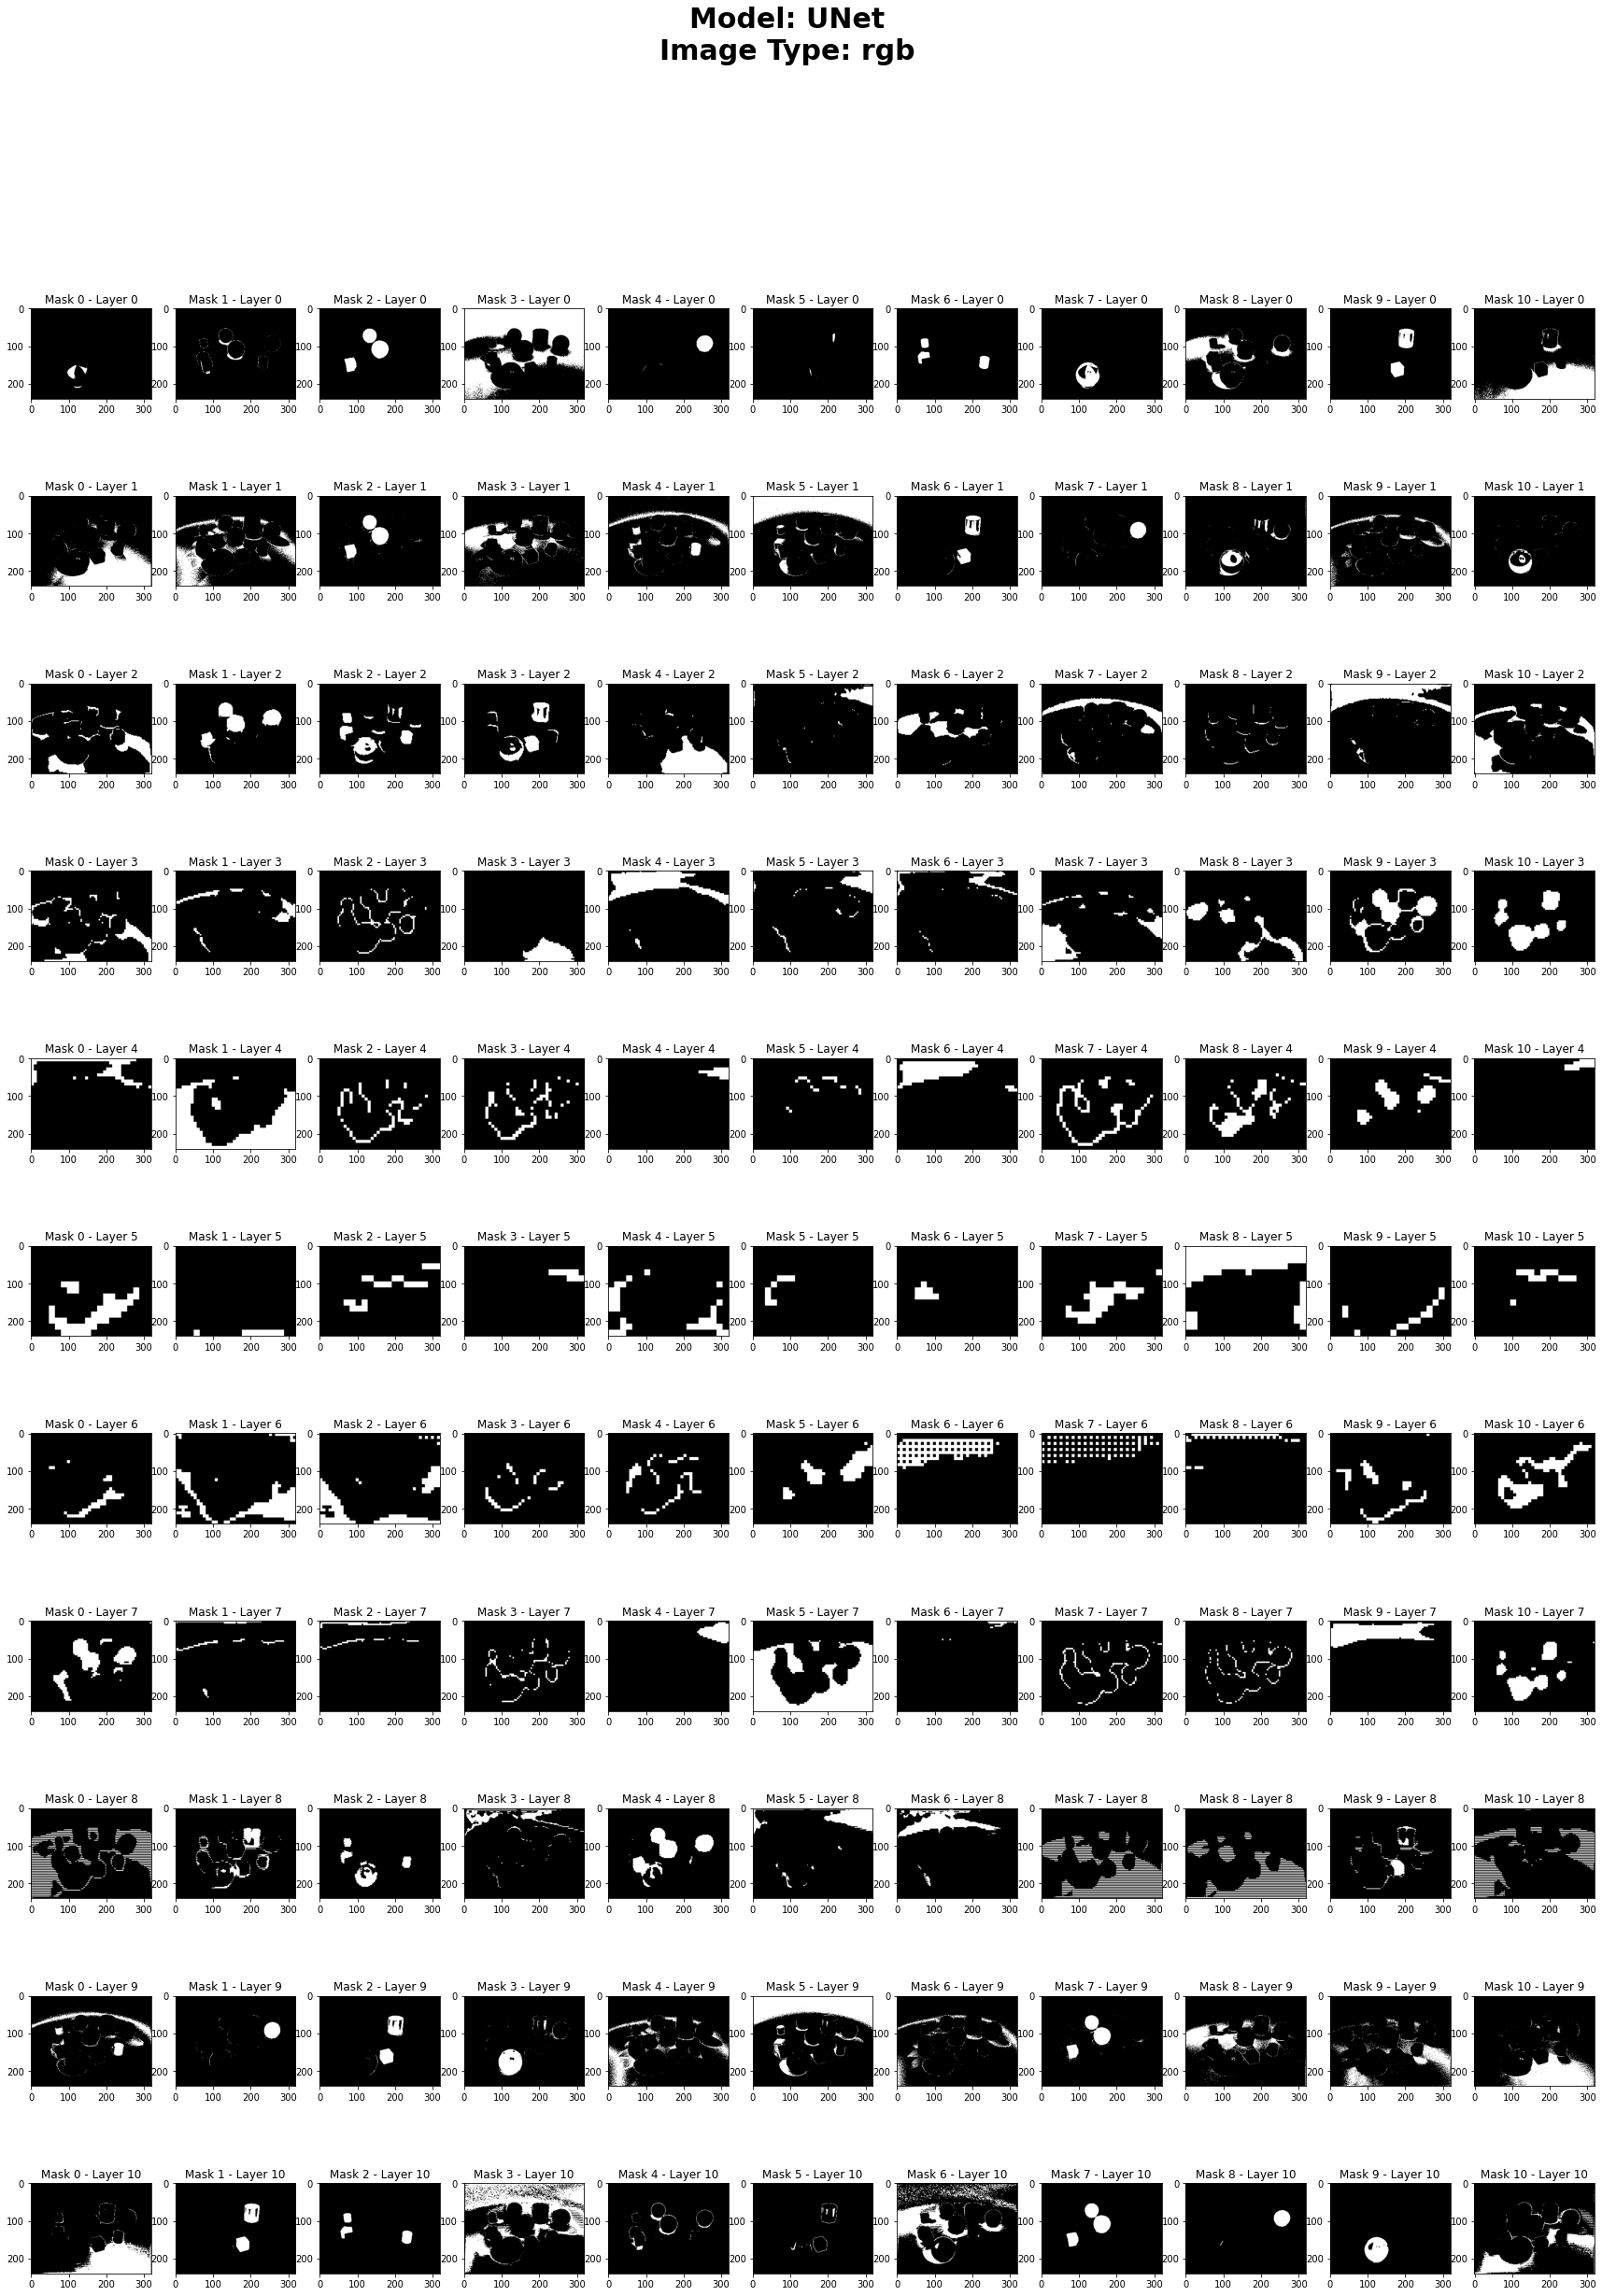

In [ ]:
# Configure the figure properties
fig = plt.figure()

# Set the properties of the figure
fig.suptitle(f'Model: {model_name}\nImage Type: {image_type}', fontsize=30, fontweight='bold')
fig.set_figheight(40)
fig.set_figwidth(30)

for jdx, labels in enumerate(mask_labels):
    # Check if image_type is grayscale or rgb
    if image_type == 'grayscale' and jdx == 0:
        continue
    
    for idx, label in enumerate(labels.unique()):
        # Create full mask
        full_mask = torch.full_like(labels, label)

        # Extract partial mask
        partial_mask = (255.0 * (full_mask == labels)).to(torch.uint8)

        # Calculate intersections
        intersections = partial_mask.logical_and(masks)

        # Calculate unions
        unions = partial_mask.logical_or(masks)

        # Calculate IoU
        IoU = intersections.sum(dim=(1, 2, 3)) / unions.sum(dim=(1, 2, 3))

        # Split subplots in two rows to ease analyzing the images
        plt.subplot(len(mask_labels), int(count), jdx * int(count) + idx + 1)

        # Show the mask label
        plt.title(f'Mask {int(label)} - Layer {jdx}')

        # Plot the mask
        plt.imshow(partial_mask.cpu().permute(1, 2, 0).repeat(1, 1, 3))

# Save the plot
plt.savefig(f'{args.output_dir}/kmeans/{model_name}_{image_type}.jpg')

# Plot the images
plt.show()

## Calculate Intersection over Union Metric

### Calculate IoU Metric Over the Test Dataset

In [5]:
from src.Metric.intersection_over_union import upsample, linearize, clusterize, segregate, jaccard_score_matrix, intersection_over_union

# Set the model to evaluation mode
model.eval()

# Declare the scores per layer list
iou_scores = []

for idx, entry in enumerate(test_dataset):
    # Send image and masks to the current available device 
    image, true_masks, objects = entry['image'].unsqueeze(0).to(args.device), entry['mask'].squeeze(1).to(args.device), entry['count']

    # Discard extra (empty) masks
    true_masks = true_masks[:objects, ...]

    # Extract the initial shape of the image
    N, C, H, W = image.shape

    # Transform the input images accordingly
    image = transform(image)

    # Pass the images through the model
    output = model(image)

    # Apply operations
    for layer, feature_map in enumerate(model.feature_maps):
        # Upsample the feature maps
        feature_map = upsample(feature_map, H, W)
        
        # Linearize the feature maps
        features = linearize(feature_map)
        
        # Clusterize into K units
        # V1: Choose K directly by using objects
        # V2: Choose K using Silhouette Metric
        labels = clusterize(features, K=objects, n_init=10)

        # Segregate the labels into separate masks
        pred_masks = segregate(labels, H, W)

        # Calculate Jaccard Matrix from TM x PM matching pairs
        jaccard_matrix = jaccard_score_matrix(true_masks, pred_masks)

        # Calculate IoU Mean for the optimally selected pairs
        iou = intersection_over_union(jaccard_matrix)

        # Append an empty list for each layer
        if len(iou_scores) == 0:
            iou_scores.extend([[] for _ in range(len(model.feature_maps))])

        # Append scores to each layer
        iou_scores[layer].append(iou)

# Nullify first layer
if image_type == 'grayscale':
    iou_scores[0].extend([torch.as_tensor(0) for _ in range(1000)])

# Calculate the IoU mean for each layer individually
layers_means = torch.Tensor(iou_scores).mean(dim=1)

Loaded ./data/input/train_test_clevr_pkls/test_clevr_8000.pkl in memory.


### Plot IoU Metric For Each Layer

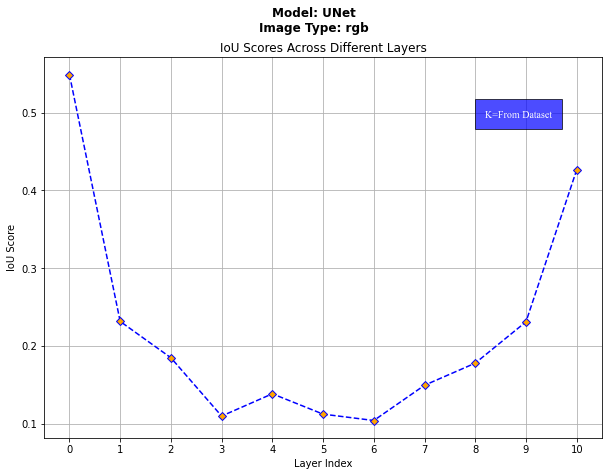

In [6]:
import matplotlib.pyplot as plt

# Create a new figure
f = plt.figure()

# Configure figure properties
f.set_figwidth(10)
f.set_figheight(7)

# Add a figure super title
f.suptitle(f'Model: {model_name}\nImage Type: {image_type}', fontweight='bold')

# Add a single subplot
ax = f.add_subplot(111)

# Create an array of all layer indexes
layer_indexes = torch.arange(0, len(layers_means))

# Plot the IoU scores
plt.plot(layer_indexes, layers_means, 'D--', c='blue', mfc='orange')

# Plot a tick on the x axis for each layer
plt.xticks(ticks=layer_indexes)

# Show the grid
plt.grid(b=True)

# Create outline box for K-Means
bbox = {'fc': 'blue', 'alpha': 0.7, 'pad': 10}

# Specify text box properties
conf = {
    'bbox': bbox,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'transform': ax.transAxes,
    'font': 'Times New Roman',
    'c': 'white'
}

# Add plot text labels
plt.text(0.85, 0.85, f'K=From Dataset', **conf)
plt.title('IoU Scores Across Different Layers')
plt.xlabel('Layer Index')
plt.ylabel('IoU Score')

# Save the plot
plt.savefig(f'{args.output_dir}/iou/graph_{model_name}_{image_type}.jpg')

# Show the plot
plt.show()

### Preview Hungarian Matching Using The Jaccard Matrix

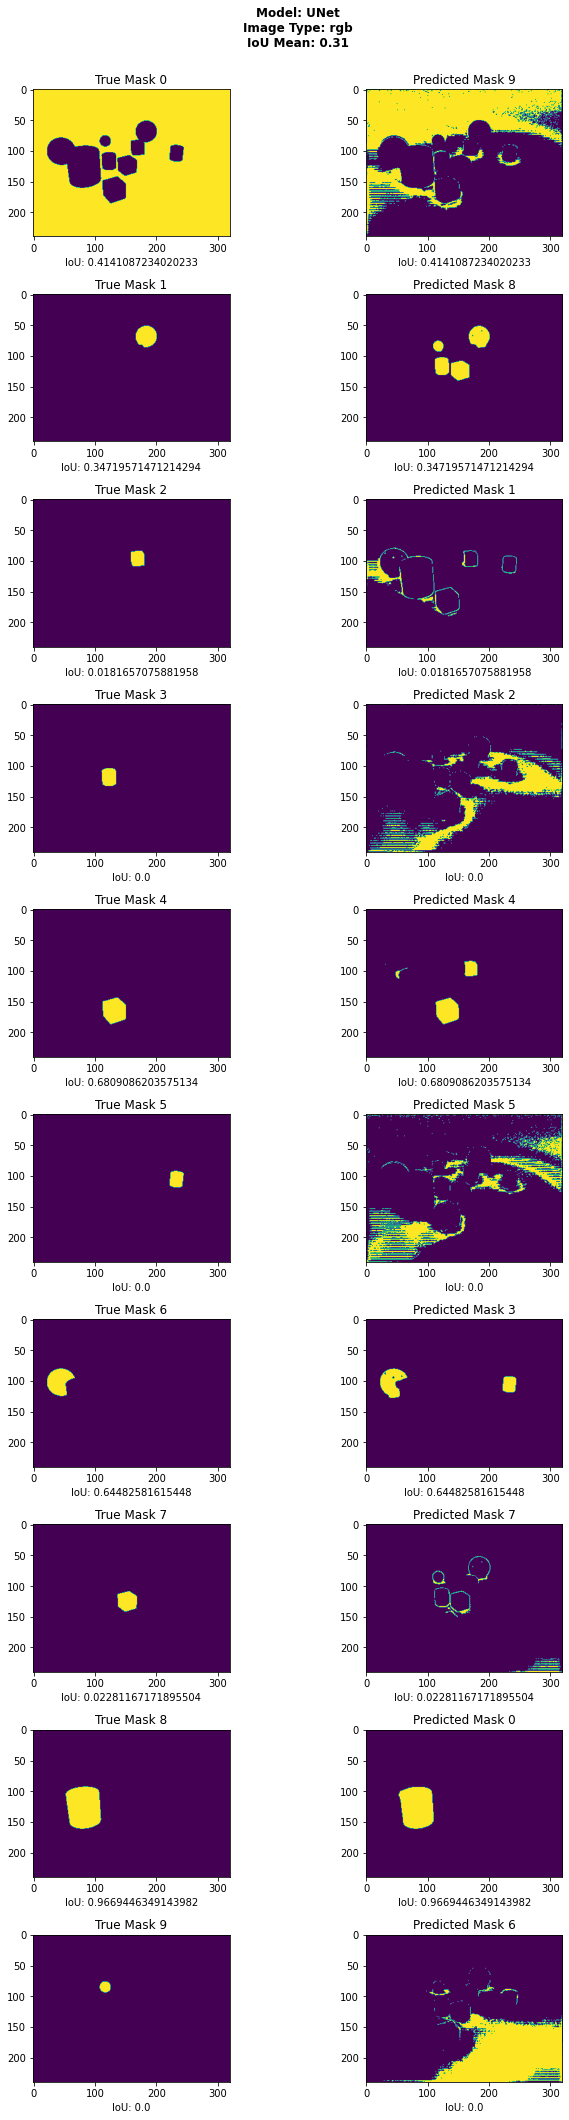

In [7]:
from scipy.optimize import linear_sum_assignment

# Calculate the most likely mask pairs according to the Jaccard Matrix
rows, cols = linear_sum_assignment(-jaccard_matrix.cpu())

# Send the results back to the GPU
rows = torch.Tensor(rows).to(torch.long).to(args.device)
cols = torch.Tensor(cols).to(torch.long).to(args.device)

# Extract the optimum matching scores
scores = jaccard_matrix[rows, cols]

# Compute the IoU mean score
iou = scores.mean()

# Configure figure properties
f = plt.figure()

# Add a figure super title
f.suptitle(f'Model: {model_name}\nImage Type: {image_type}\nIoU Mean: {iou:.02}\n\n\n', fontweight='bold')

# Configure figure properties
f.set_figwidth(10)
f.set_figheight(30)

# Show matches
for i in range(rows.shape[0]):
    # Print the true masks
    plt.subplot(rows.shape[0], 2, 2 * i + 1)
    plt.title(f'True Mask {rows[i]}')
    plt.imshow(true_masks[rows[i]].cpu())
    plt.xlabel(f'IoU: {jaccard_matrix[rows[i], cols[i]]}')

    # Print the predicted masks
    plt.subplot(rows.shape[0], 2, 2 * i + 2)
    plt.title(f'Predicted Mask {cols[i]}')
    plt.imshow(pred_masks[cols[i]].cpu())
    plt.xlabel(f'IoU: {jaccard_matrix[rows[i], cols[i]]}')

# Create boundaries around each plot
plt.tight_layout()

# Save the plot
plt.savefig(f'{args.output_dir}/iou/matching_{model_name}_{image_type}.jpg')

# Show the plots
plt.show()

## Using Supervised Models on the **CLEVR (with masks)** Dataset

In [2]:
import torch

def aggregate(masks: torch.Tensor, shapes: torch.Tensor) -> torch.Tensor:
    """
        This function takes as input ground truth masks of size
        (N, 11, 1, H, W) and a shapes tensor of size (N, 11).
        
        Each set of masks is aggregated into a single image,
        using the correspondent shapes tensor.

        The output is a mask tensor of size (N, H, W), according
        to the Pytorch loss function headers.
    """
    # Prepare shapes for broadcasting
    shapes = shapes.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

    # Map masks from [0, 255] to [0, 1]
    masks = torch.clamp(masks, min=0, max=1.0)

    # Specify a class for each mask
    masks = masks * shapes

    # Aggregate masks
    masks = masks.sum(dim=(1, 2))

    # Return the output
    return masks

In [3]:
from src.Config.Args import args
import torch

def train(model, train_loader, optimizer, criterion, epoch, transform):
    # Set the model to training mode
    model.train()

    # Retain a history of losses
    all_losses = []

    # Iterate through the data loarder and train the model
    for batch_idx, entry in enumerate(train_loader):
        # Send the data to the available GPU
        images = entry['image'].to(args.device)
        shapes = entry['shape'].to(args.device)
        masks = entry['mask'].to(args.device)

        # Preprocess the images
        images = transform(images)
        
        # Reset the gradients back to zero before calculating new loss
        optimizer.zero_grad()

        # Compute the output of the model
        output = model(images)

        # Aggregate the ground truth masks
        masks = aggregate(masks, shapes)

        # Calculate the loss accordingly
        loss = criterion(output, masks)

        # Add the current loss to the history
        all_losses.append(loss.cpu())

        # Use backpropagation to calculate the new gradients
        loss.backward()

        # Use a custom optimizer to adjuts the parameters of the model
        optimizer.step()

        # Show updates regularly
        if batch_idx % args.log_interval == 0 or batch_idx == len(train_loader) - 1:
            print(f'Train Epoch: {epoch} ', end='')
            print(f'[{batch_idx * images.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]', end='')
            print(f'\tLoss: {loss.item()}')

    # Return the losses of this epoch
    return torch.tensor(all_losses).mean()

In [5]:
from src.Model.UNet.UNetCNN import UNetCNN

# The maximum number of shapes is 4 (including the background)
model = UNetCNN(in_channels=3, out_channels=4, n_filters=8).to(args.device)

# Specify the optimizer used to train the model
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)

# Specify the criterion that will be used to penalize the model
criterion = torch.nn.CrossEntropyLoss()

In [6]:
from src.Plotter import plot_loss
from src.Process import process
import torch

# Retain the loss evolution
losses_train = []

# Train the model for a number of epochs
for epoch in range(args.epochs):
    # Train the model for one epoch
    train_loss = train(model, train_loader, optimizer, criterion, epoch, process)

    # Retain the current loss
    losses_train.append(train_loss)

    # Separate the outputs
    print()

# Plot the loss evolution
plot_loss(losses_train, 'train_loss', 'Train Loss', 'Epoch', 'Loss')

Loaded ./data/input/train_test_clevr_pkls/train_clevr_3000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_6000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_5000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_7000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_2000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_4000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_1000.pkl in memory.
Train Epoch: 0 [0/7000 (0%)]	Loss: 1.3925673961639404


KeyboardInterrupt: 

In [ ]:
# Save the weights on disk
torch.save(model.state_dict(), 'data/temp/model/rgb/SupervisedUNet.pt')

In [5]:
from src.Model.UNet.UNetCNN import UNetCNN
import torch

# The maximum number of shapes is 4 (including the background)
model = UNetCNN(in_channels=3, out_channels=4, n_filters=8).to(args.device)

# Load the model trained parameters in memory
model.load_state_dict(torch.load('data/temp/model/rgb/SupervisedUNet.pt'))

<All keys matched successfully>

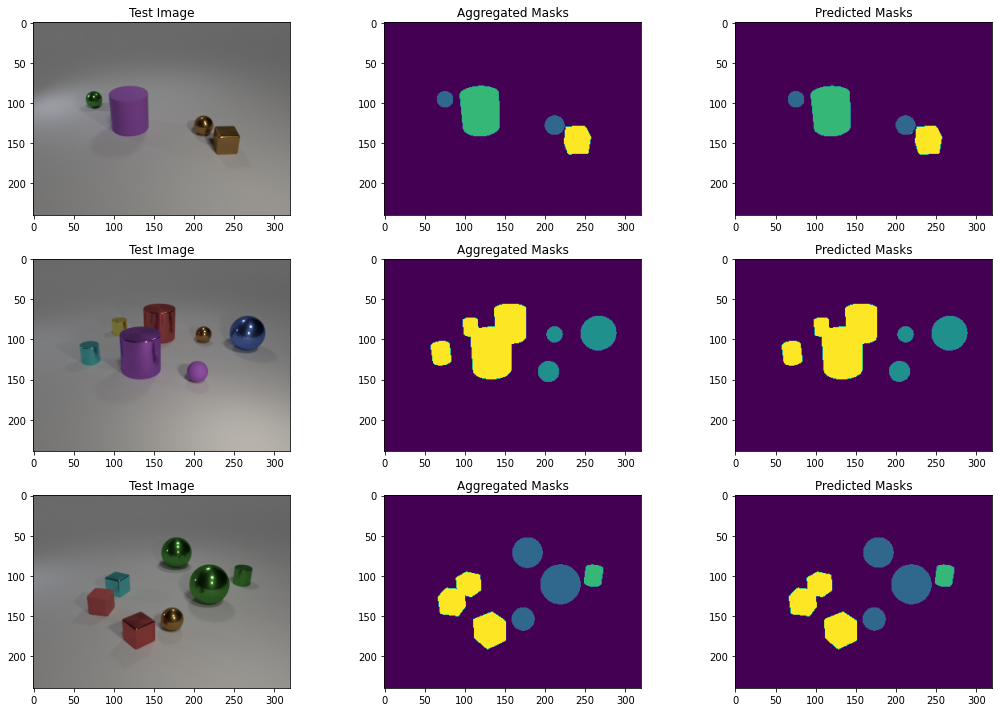

In [10]:
import matplotlib.pyplot as plt
from src.Process import process

# Set the model to evaluation mode
model.eval()

# Create a new plot
fig = plt.figure()

# Configure the properties
fig.set_figheight(10)
fig.set_figwidth(15)

# Specify a number of test cases
num_test_cases = 3

for idx, entry in enumerate(test_loader):
    # Send the columns to the GPU
    image, masks, shapes = entry['image'][0].to(args.device), entry['mask'].to(args.device), entry['shape'].to(args.device)
    
    # Aggregate the mask labels into a single image
    masks = aggregate(masks, shapes)[0]

    # Process the input image
    image = process(image)

    # Send the image to the model
    output = model(image.unsqueeze(0))
    
    # Squeeze the first dimension
    output = output.squeeze(0)

    # Select the most likely classes
    output = torch.argmax(output, dim=0)

    # Draw the input test image
    plt.subplot(num_test_cases, 3, (idx * 3) + 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.title('Test Image')

    # Draw the aggregated ground truth masks
    plt.subplot(num_test_cases, 3, (idx * 3) + 2)
    plt.title('Aggregated Masks')
    plt.imshow(masks.cpu())

    # Draw the predicted masks
    plt.subplot(num_test_cases, 3, (idx * 3) + 3)
    plt.imshow(output.detach().cpu())
    plt.title('Predicted Masks')
    
    # End the iteration early
    if idx == num_test_cases - 1:
        break

# Draw some space between images
plt.tight_layout()